In [1]:
import pandas as pd
import numpy as np
from cuml.svm import SVR as cuSVR
from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.preprocessing import StandardScaler as cuScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# Load the dataset
file_path = 'barriers_v2_100K.zip'
data = pd.read_csv(file_path, compression='zip')

In [3]:
# Prepare the features and target variable
X = data[['Strike', 'Barrier', 'Maturity', 'Spot', 'Rate', 'Volatility', 'BarrierType', 'ExerciseType', 'OptionType']]
y = data['Price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using cuML scaler for GPU acceleration
scaler = cuScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Train and evaluate GPU-accelerated SVM model
svm_model = cuSVR(kernel='rbf')
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

In [5]:
# Train and evaluate GPU-accelerated Random Forest model
rf_model = cuRF(n_estimators=100, random_state=42, n_streams=1)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

/home/bren/anaconda3/envs/rapids-24.12/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


In [6]:
# Train and evaluate GPU-accelerated Gradient Boosting model using XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'device': "cuda"
}
gbdt_model = xgb.train(params, dtrain, num_boost_round=100)
y_pred_gbdt = gbdt_model.predict(dtest)

In [7]:
# Evaluate models
models = {'SVM': y_pred_svm, 'Random Forest': y_pred_rf, 'GBDT': y_pred_gbdt}

for model_name, y_pred in models.items():
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - Mean Squared Error: {mse}, R^2 Score: {r2}")

SVM - Mean Squared Error: 5618942.245387723, R^2 Score: -0.040741153655543094
Random Forest - Mean Squared Error: 2207999.97194898, R^2 Score: 0.5910339815356079
GBDT - Mean Squared Error: 365049.25474219053, R^2 Score: 0.9323855334456694


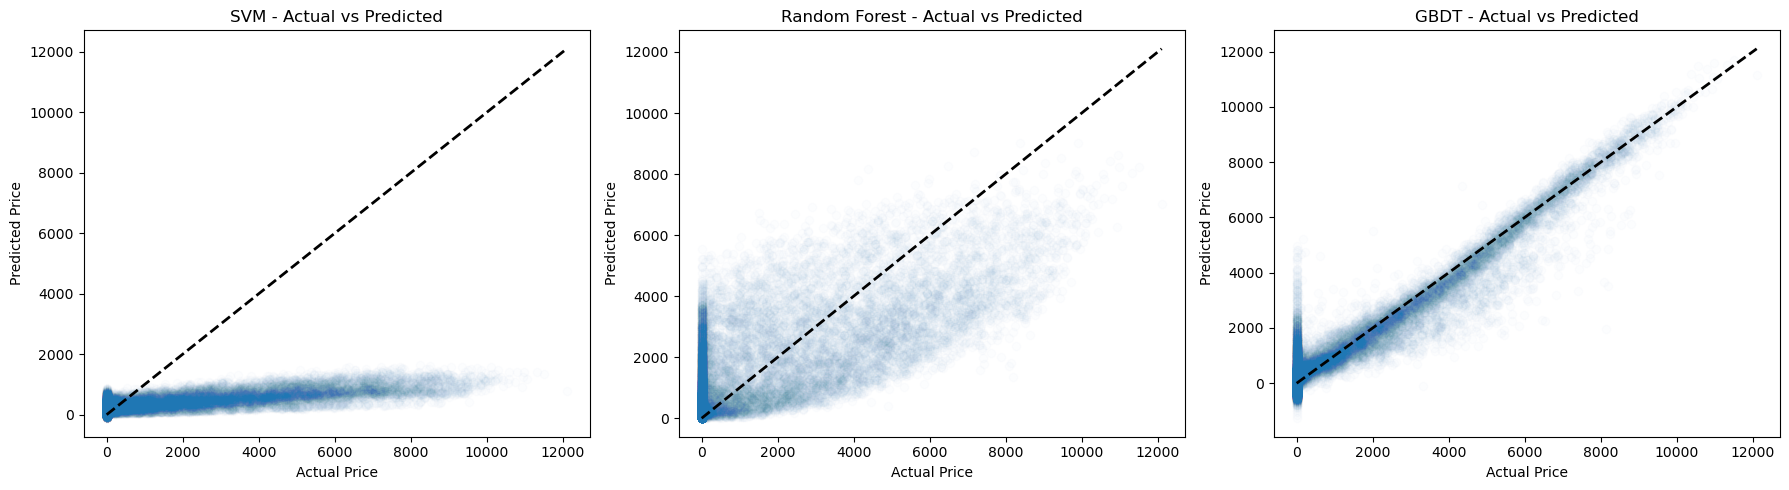

In [10]:
# Plot the actual vs predicted values for each model
plt.figure(figsize=(18, 5))
for i, (model_name, y_pred) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test, y_pred, alpha=0.01)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{model_name} - Actual vs Predicted')

plt.tight_layout()
plt.show()

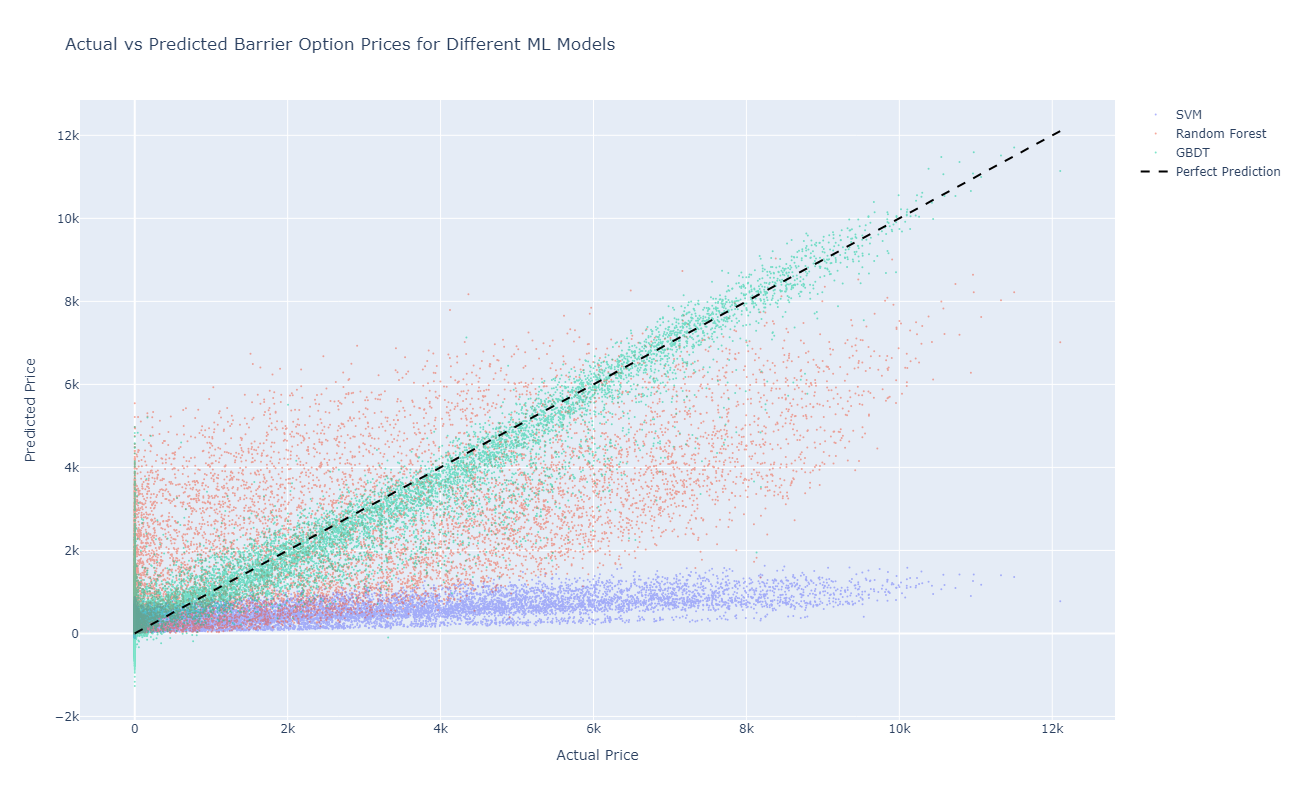

In [24]:
# Plot the actual vs predicted values for each model using Plotly
fig = go.Figure()
for model_name, y_pred in models.items():
    fig.add_trace(go.Scatter(x=y_test, y=y_pred, mode='markers', name=model_name, opacity=0.5, marker_size=2))
fig.add_trace(go.Scatter(x=[y.min(), y.max()], y=[y.min(), y.max()], mode='lines', name='Perfect Prediction', line=dict(dash='dash', color='black')))
fig.update_layout(
    title='Actual vs Predicted Barrier Option Prices for Different ML Models',
    xaxis_title='Actual Price',
    yaxis_title='Predicted Price',
    showlegend=True,
    autosize=False,
    width=800,
    height=800,
)
fig.show()

